In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.patches import Circle
from scipy import signal

In [5]:
def zplane_plot(ax, z, p, k):
    """Plot pole/zero/gain plot of discrete-time, linear-time-invariant system.

    Note that the for-loop handling might be not very efficient
    for very long FIRs

    z...array of zeros in z-plane
    p...array of poles in z-zplane
    k...gain factor

    taken from own work
    URL = ('https://github.com/spatialaudio/signals-and-systems-exercises/'
           'blob/master/sig_sys_tools.py')

    currently we don't use the ax input parameter, we rather just plot
    in hope for getting an appropriate place for it from the calling function
    """
    # draw unit circle
    Nf = 2**7
    Om = np.arange(Nf) * 2*np.pi/Nf
    plt.plot(np.cos(Om), np.sin(Om), 'C7')

    try:  # TBD: check if this pole is compensated by a zero
        circle = Circle((0, 0), radius=np.max(np.abs(p)),
                        color='C7', alpha=0.15)
        plt.gcf().gca().add_artist(circle)
    except ValueError:
        print('no pole at all, ROC is whole z-plane')

    zu, zc = np.unique(z, return_counts=True)  # find and count unique zeros
    for zui, zci in zip(zu, zc):  # plot them individually
        plt.plot(np.real(zui), np.imag(zui), ms=8,
                 color='C0', marker='o', fillstyle='none')
        if zci > 1:  # if multiple zeros exist then indicate the count
            plt.text(np.real(zui), np.imag(zui), zci)

    pu, pc = np.unique(p, return_counts=True)  # find and count unique poles
    for pui, pci in zip(pu, pc):  # plot them individually
        plt.plot(np.real(pui), np.imag(pui), ms=8,
                 color='C0', marker='x')
        if pci > 1:  # if multiple poles exist then indicate the count
            plt.text(np.real(pui), np.imag(pui), pci)

    plt.text(0, +1, 'k={0:f}'.format(k))
    plt.text(0, -1, 'ROC for causal: white')
    plt.axis('square')
    plt.xlabel(r'$\Re\{z\}$')
    plt.ylabel(r'$\Im\{z\}$')
    plt.grid(True, which="both", axis="both",
             linestyle="-", linewidth=0.5, color='C7')


def bode_plot(b, N=2**10, fig=None):  # we use this here for FIRs only
    if fig is None:
        fig = plt.figure()

    a = np.zeros(len(b))  # some scipy packages need len(a)==len(b)
    a[0] = 1

    z, p, gain = signal.tf2zpk(b, a)
    W, Hd = signal.freqz(b, a, N, whole=True)

    print('number of poles:', len(p), '\npole(s) at:', p,
          '\nnumber of zeros:', len(z), '\nzero(s) at:', z)

    gs = fig.add_gridspec(2, 2)
    # magnitude
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(W/np.pi, np.abs(Hd), "C0",
             label=r'$|H(\Omega)|$)',
             linewidth=2)
    ax1.set_xlim(0, 2)
    ax1.set_xticks(np.arange(0, 9)/4)
    ax1.set_xlabel(r'$\Omega \,/\, \pi$', color='k')
    ax1.set_ylabel(r'$|H|$', color='k')
    ax1.set_title("Magnitude response", color='k')
    ax1.grid(True, which="both", axis="both",
             linestyle="-", linewidth=0.5, color='C7')

    # phase
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(W/np.pi, (np.angle(Hd)*180/np.pi), "C0",
             label=r'$\mathrm{angle}(H('r'\omega))$',
             linewidth=2)
    ax2.set_xlim(0, 2)
    ax2.set_xticks(np.arange(0, 9)/4)
    ax2.set_xlabel(r'$\Omega \,/\, \pi$', color='k')
    ax2.set_ylabel(r'$\angle(H)$ / deg', color='k')
    ax2.set_title("Phase response", color='k')
    ax2.grid(True, which="both", axis="both",
             linestyle="-", linewidth=0.5, color='C7')

    # zplane
    ax3 = fig.add_subplot(gs[0, 1])
    zplane_plot(ax3, z, p, gain)

    # impulse response
    N = 2**3  # here specially chosen for the examples below
    k = np.arange(N)
    x = np.zeros(N)
    x[0] = 1  # create a Dirac
    h = signal.lfilter(b, a, x)
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.stem(k, h, linefmt='C0', markerfmt='C0o',
             basefmt='C0:')
    ax4.set_xlabel(r'$k$')
    ax4.set_ylabel(r'$h[k]$')
    ax4.set_title('Impulse Response')
    ax4.grid(True, which="both", axis="both", linestyle="-",
             linewidth=0.5, color='C7')


def plot_windowed_FIR_design():
    hw = h*w
    W = np.arange(0, 2**10) * 2*np.pi / 2**10
    [_, H] = signal.freqz(h, a=1, worN=W)
    [_, Hw] = signal.freqz(hw, a=1, worN=W)
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(k, h, 'C3o-', label='rectangular windowed FIR h[k]')
    plt.plot(k, w, 'C7o-', label='Kaiser Bessel window w[k]')
    plt.plot(k, hw, 'C0o-', label='Kaiser-Bessel windowed FIR hw[k]')
    plt.xlabel('k')
    plt.title('Impulse responses and window')
    plt.legend()
    plt.grid(True)
    plt.subplot(2, 1, 2)
    plt.plot([W[0]/np.pi, W[-1]/np.pi], [0, 0], 'C7')
    plt.plot([W[0]/np.pi, W[-1]/np.pi], [-6, -6], 'C1')
    plt.plot([W[0]/np.pi, W[-1]/np.pi], [-21, -21], 'C3:')
    plt.plot([W[0]/np.pi, W[-1]/np.pi],
             [StopBandMaxLevel, StopBandMaxLevel], 'C0:')
    plt.plot([Wc/np.pi, Wc/np.pi], [StopBandMaxLevel, 0],
             'C1', label=r'-6dB @ $\Omega_c$')
    plt.plot(W/np.pi, 20*np.log10(np.abs(H)), color='C3',
             label='rectangular windowed FIR')
    plt.plot(W/np.pi, 20*np.log10(np.abs(Hw)), color='C0',
             label='Kaiser-Bessel windowed FIR')
    plt.xlim((0, 2))
    plt.yticks(np.arange(-6-12*8, 12, 12))
    plt.xlabel(r'$\Omega \,/\, \pi$')
    plt.ylabel(r'$20\lg|H(\Omega)|$ / dB')
    plt.title('Level response')
    plt.legend()
    plt.grid(True)


# some defaults for the upcoming code:
figsize = (12, 9)

number of poles: 2 
pole(s) at: [0. 0.] 
number of zeros: 2 
zero(s) at: [-0.5+1.93649167j -0.5-1.93649167j]


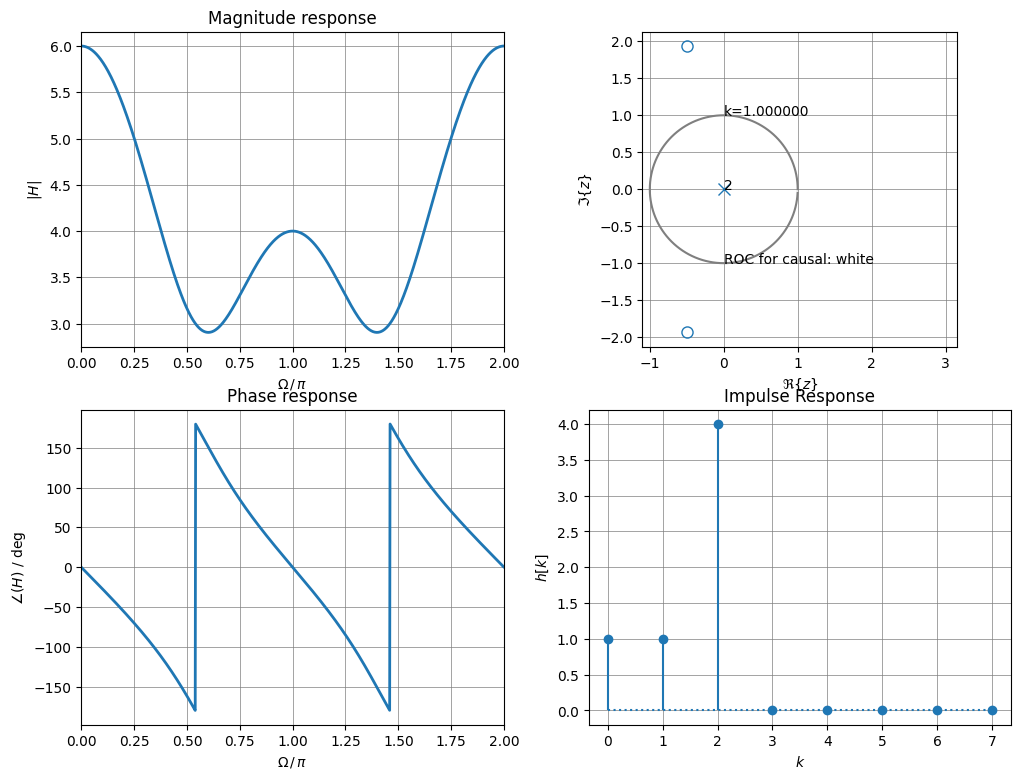

In [6]:
b = [1, 1, 4]  # linear phase FIR Type I, the zero in between counts as coeff
bode_plot(b, fig=plt.figure(figsize=figsize))